In [2]:
import panel as pn
import xarray as xr
import pygmt
import matplotlib.pyplot as plt

pn.extension()

In [ ]:
! wget --no-check-certificate 'https://gws-access.jasmin.ac.uk/public/nceo_geohazards/shared/temp/earmla/bangkok/ML5smooth/bangkok_dec_plus_cum_ok_small.nc' -O temp.nc

In [ ]:
# loading the netcdf as xarray dataset
import xarray as xr
nc=xr.open_dataset('temp.nc')

nc['cum']=nc.cum_pseudovertical
coordsys = "epsg:4326"
nc = nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc = nc.rio.write_crs(coordsys, inplace=True)


In [ ]:

# run the preview through jupyter notebook - load necessary modules
import geoviews as gv
import holoviews as hv
import numpy as np
import geoviews.feature as gf
from geoviews import opts, tile_sources as gvts
from cartopy import crs
import panel as pn
from holoviews import streams
from matplotlib.figure import Figure
gv.extension('bokeh', 'matplotlib')
gv.output() #size=200)

In [ ]:

# get only velocity to show in map
vel = gv.Image(nc['U'], ['lon','lat'])
themap = vel.opts(cmap='RdBu_r', colorbar=True, backend='bokeh')


# make a function that displays info at selected point
def showvel(x, y):
    try:
        selvel=np.float32(nc.U.sel(lat=y, lon=x, method='nearest'))
        #selcoh=np.float32(nc.coh.sel(lat=y, lon=x, method='nearest'))
    except:
        selvel=0
        #selcoh=0
    return pn.pane.Str('vertical deformation: %0.2f' %selvel +' mm/year',width=300)

# Time series viewer function

# add layer to register taps (selected point)
tap = streams.SingleTap(transient=True)

def do_tap(x,y):
    return hv.Points([(x,y)])

taps_dmap = hv.DynamicMap(do_tap, streams=[tap])
taps_dmap.opts(color='black', size=5) #, tools=['hover'])


## set limits to time series
## ylims = (nc.cum.quantile(0.005),nc.cum.quantile(0.995))
#ylims = (nc.cum.min(),nc.cum.max())
ylims = (-50,50)
def plotts(x, y):
    try:
        selts=nc.sel(lat=y, lon=x, method='nearest').cum_pseudovertical
        times=selts.time.values
        vals=selts.values
        fig = Figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_title('(pseudo-)vertical deformation')
        ax.set_ylabel('mm')
        ax.set_ylim(ylims)
        ax.grid('on')
        cf=ax.scatter(times,vals)
        return pn.pane.Matplotlib(fig)
    except:
        return pn.pane.Str('click to the map to show time series')


# add interactive transparency slider
opacity_slider = pn.widgets.FloatSlider(start=0, end=1, value=0.5, name='Opacity') #, throttled=True)

@pn.depends(alpha=opacity_slider)
def viewmap(alpha):
    fullmap = gvts.EsriImagery * gvts.OSM.apply.opts(alpha=0.5) * themap.apply.opts(alpha=alpha)*  taps_dmap  # not working on binder: gvts.StamenTerrainRetina * taps_dmap
    return fullmap

# set the click events (tapping) and run the layout
stream = hv.streams.Tap(source=themap, x=np.nan, y=np.nan)
layout = pn.Row(pn.Column(opacity_slider, viewmap),
                pn.Column(pn.bind(showvel, x=stream.param.x, y=stream.param.y),
                          pn.bind(plotts, x=stream.param.x, y=stream.param.y))
               )


layout #.servable()

In [ ]:
print('preparing seasonal medians')
nca= nc.cum.resample(time='A') 
nc['annual'] = nca.max() - nca.min()
#Ds= D.cum.resample(time='Q').median()
print('done')

In [ ]:
#! panel serve --show --port 5009 bangkok.ipynb

In [8]:
# preparation for plot
# just fast solution, but it works
timevals = []
i=0
for a in cube.time.values:
    i=i+1
    timevals.append(i-1)

# Make a panel widget for controlling the depth plotted
depth_slider = pn.widgets.DiscreteSlider(name='LOS deformation (mm) in step', options=timevals, value=1)

# aliases
As = cube.As
Ds = cube.Ds
Es = cube.Es
Us = cube.Us

In [40]:

# Make a function for plotting with PyGMT
@pn.depends(depth=depth_slider)
def view(depth: int, save=False):
    if depth == 0:
        depth = 1
    fig = pygmt.Figure()
    pygmt.config(FONT_HEADING='22p,Helvetica-Bold,black')
    t2=str(As[depth].time.dt.quarter.values)+'.'+str(As[depth].time.dt.year.values)
    t1=str(As[depth-1].time.dt.quarter.values)+'.'+str(As[depth-1].time.dt.year.values)
    maintitle = 'deformation between Q'+t1+' and Q'+t2
    with fig.subplot(nrows=2, ncols=2, figsize=("30c", "24c"), margins=["0.75c", "0.5c"], 
                     title=maintitle, frame = 'a'): #, autolabel=True):
        with fig.set_panel(panel=0):
            pygmt.makecpt(cmap="roma", series=[-40,40])
            fig.grdimage(grid=(As[depth]-As[depth-1]), cmap=True, projection="R?") #13c") #, frame=True) #, panel=True)
            fig.colorbar(frame='a10+l"LOS deformation [mm]"')
            fig.text(position="TC", 
                     text='ascending frame',
                     #xshift = '-0.02c', yshift = '-0.01c',
                     font="22p,Helvetica-Bold,black"
                    )
            fig.text(x=-27.75,y=38.74, justify='TR', text='Q'+t1+': '+str(Ascount[depth-1])+' epochs ', font="16p")
            fig.text(x=-27.75,y=38.715, justify='TR', text='Q'+t2+': '+str(Ascount[depth])+' epochs ', font="16p")
        with fig.set_panel(panel=1):
            pygmt.makecpt(cmap="roma", series=[-40,40])
            fig.grdimage(grid=(Ds[depth]-Ds[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"LOS deformation [mm]"')
            fig.text(position="TC", text='descending frame', font="22p,Helvetica-Bold,black")
            fig.text(x=-27.75,y=38.74, justify='TR', text='Q'+t1+': '+str(Dscount[depth-1])+' epochs ', font="16p")
            fig.text(x=-27.75,y=38.715, justify='TR', text='Q'+t2+': '+str(Dscount[depth])+' epochs ', font="16p")
        with fig.set_panel(panel=2):
            pygmt.makecpt(cmap="vik", series=[-40,40])
            fig.grdimage(grid=(Us[depth]-Us[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"U-D/N-S deformation [mm]"')
            fig.text(position="TC", text='up-down(+N-S) component', font="22p,Helvetica-Bold,black")
        with fig.set_panel(panel=3):
            pygmt.makecpt(cmap="vik", series=[-40,40])
            fig.grdimage(grid=(Es[depth]-Es[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"E-W deformation [mm]"')
            fig.text(position="TC", text='east-west component', font="22p,Helvetica-Bold,black")
    if save:
        fname='step_'+str(depth)+'.png'
        fig.savefig(fname, dpi=150)
    else:
        return fig.show(dpi=100)

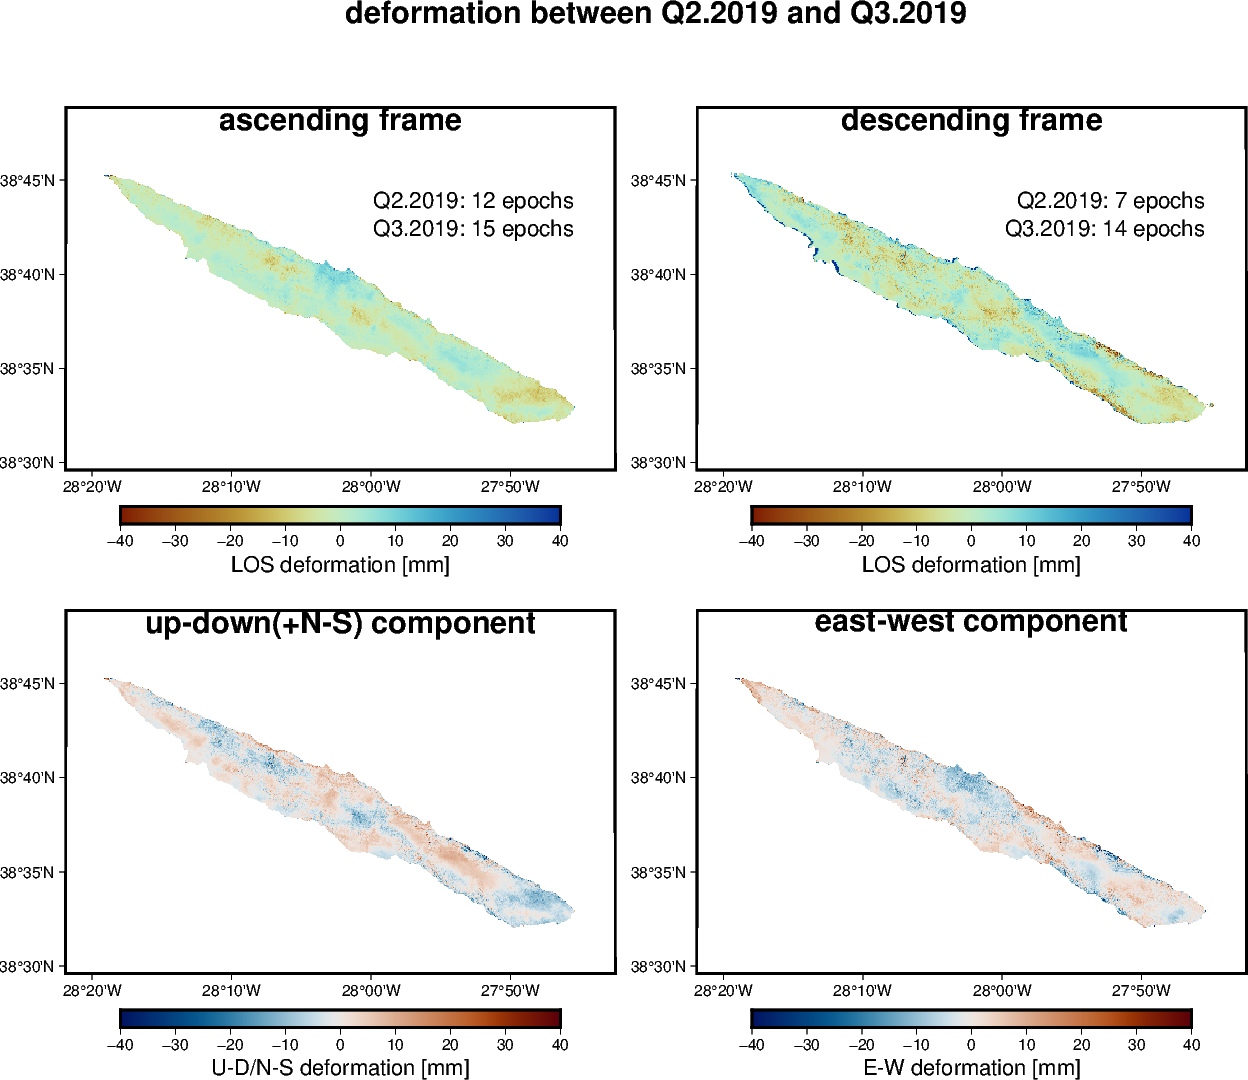

Column
    [0] DiscreteSlider(formatter='%d', name='LOS deformation (..., options=[0, 1, 2, 3, 4, ...], value=1)
    [1] ParamFunction(function)

In [41]:
pn.Column(depth_slider, view)

In [ ]:
# you can save the step to pngs:
for i in range(13):
    print('saving step '+str(i+1))
    view(i+1, save=True)

saving step 1
saving step 2
saving step 3
saving step 4
saving step 5
saving step 6
saving step 7
saving step 8
saving step 9


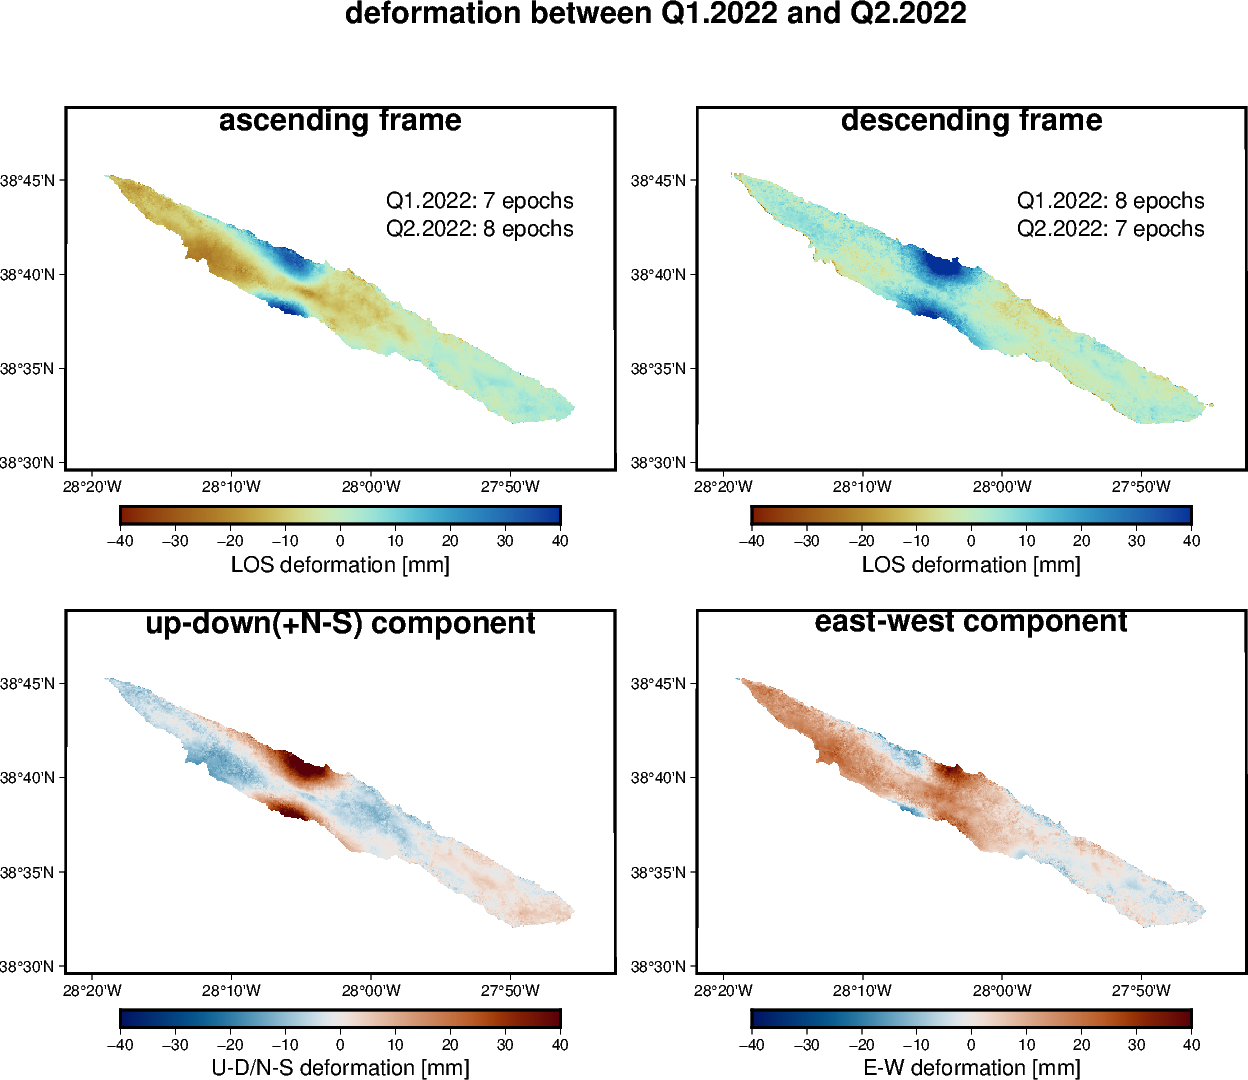

In [42]:
# or just view one of the steps directly
view(12)